<a href="https://colab.research.google.com/github/elampietti/Coursera_Capstone/blob/master/RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# install dependencies: 
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-n45w9m3t
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-n45w9m3t
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [13]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


In [3]:
# Get training and validation data for VOC 2007
!curl -L "https://app.roboflow.com/ds/ji2cS6UUK4?key=SCGzhDvz6i" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/000032_jpg.rf.ccbf955025e7faaaf56365032669eb24.jpg  
 extracting: train/000033_jpg.rf.f04a671ff5f72e1ab5cdb529c37281e4.jpg  
 extracting: train/000035_jpg.rf.130ed241b37783501d8bde9d1b18ae19.jpg  
 extracting: train/000039_jpg.rf.873f92167e1614627c87e71a59e1be4a.jpg  
 extracting: train/000041_jpg.rf.5d834660d4df303f6d93569a517cd198.jpg  
 extracting: train/000044_jpg.rf.f1b4e9ee58c610fdbbc0ead4dd9e39f8.jpg  
 extracting: train/000046_jpg.rf.1e23099c97faa6dfeaeb0bb32632a0ee.jpg  
 extracting: train/000047_jpg.rf.d96fa644c7f2df6ffa83434e0da0b9be.jpg  
 extracting: train/000048_jpg.rf.d5b9862f0d9dbea05c9d8b070a71f4c0.jpg  
 extracting: train/000050_jpg.rf.6292253768ef78166e37040d9df63eb4.jpg  
 extracting: train/000052_jpg.rf.4509d875a84e0355563a1b569d4f3494.jpg  
 extracting: train/000060_jpg.rf.cd565794bde64d9454b2463e6c4fdbc5.jpg  
 extracting: train/000061_jpg.rf.d0b404d71e87567aec6ec590157c2620.jpg  
 extracting: 

In [10]:
# Get test data for VOC 2007
!curl -L "https://app.roboflow.com/ds/BfERhbEO1E?key=82JnLtE0Z5" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   879  100   879    0     0   1993      0 --:--:-- --:--:-- --:--:--  1988
100  149M  100  149M    0     0  80.1M      0  0:00:01  0:00:01 --:--:--  138M
Archive:  roboflow.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: README.dataset.txt      
replace README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/000001_jpg.rf.934e282b46b3e4089da72ca862bcab31.jpg  
 extracting: test/000002_jpg.rf.f3340dfd468e1ad74a8602da1c38a227.jpg  
 extracting: test/000003_jpg.rf.c38f0a284fc17cb85f2b360e9a32d084.jpg  
 extracting: test/000004_jpg.rf.88315faf6665c520c51c97496115d928.jpg  
 extracting: test/000006_jpg.rf.df3d954d98d0c6ee6db5bc007053b13c.jpg  
 extracting: test/000008_jpg.rf.64f98c8f6e9405a6418f35ef7f3d65a4.jpg  
 ex

In [18]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

AssertionError: ignored

WARNING [10/24 22:38:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/24 22:38:18 d2.data.datasets.coco]: Loaded 3506 images in COCO format from /content/train/_annotations.coco.json


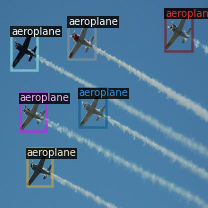

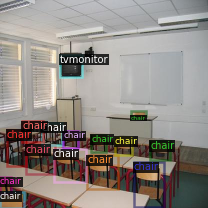

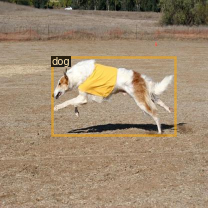

In [5]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")
import random
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [19]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21
cfg.MODEL.RETINANET.NUM_CLASSES = 21
cfg.TEST.EVAL_PERIOD = 500

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [8]:
import os
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/24 22:46:16 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_b796dc.pkl: 152MB [00:04, 31.2MB/s]                           
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (189, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (189,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
head.cls_score.{bias, weight}


[10/24 22:46:24 d2.engine.train_loop]: Starting training from iteration 0
[10/24 22:46:59 d2.utils.events]:  eta: 0:43:39  iter: 19  total_loss: 1.692  loss_cls: 1.474  loss_box_reg: 0.186  time: 1.7566  data_time: 0.0636  lr: 0.000020  max_mem: 3032M
[10/24 22:47:34 d2.utils.events]:  eta: 0:43:28  iter: 39  total_loss: 1.041  loss_cls: 0.951  loss_box_reg: 0.096  time: 1.7701  data_time: 0.0164  lr: 0.000040  max_mem: 3032M
[10/24 22:48:11 d2.utils.events]:  eta: 0:43:03  iter: 59  total_loss: 1.171  loss_cls: 1.022  loss_box_reg: 0.149  time: 1.7912  data_time: 0.0161  lr: 0.000060  max_mem: 3032M
[10/24 22:48:48 d2.utils.events]:  eta: 0:42:46  iter: 79  total_loss: 1.182  loss_cls: 1.045  loss_box_reg: 0.123  time: 1.8027  data_time: 0.0177  lr: 0.000080  max_mem: 3032M
[10/24 22:49:24 d2.utils.events]:  eta: 0:42:13  iter: 99  total_loss: 1.050  loss_cls: 0.952  loss_box_reg: 0.088  time: 1.8029  data_time: 0.0201  lr: 0.000100  max_mem: 3032M
[10/24 22:50:01 d2.utils.events]:  e

In [20]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/output/", "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
# evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="/content/drive/MyDrive/output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [10/25 01:51:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/25 01:51:37 d2.data.datasets.coco]: Loaded 4952 images in COCO format from /content/test/_annotations.coco.json
[10/25 01:51:37 d2.data.build]: Distribution of instances among all 21 categories:
|  category  | #instances   |  category   | #instances   |  category   | #instances   |
|:----------:|:-------------|:-----------:|:-------------|:-----------:|:-------------|
|  Objects   | 0            |  aeroplane  | 311          |   bicycle   | 389          |
|    bird    | 576          |    boat     | 393          |   bottle    | 657          |
|    bus     | 254          |     car     | 1541         |     cat     | 370          |
|   chair    | 1374         |     cow     | 329          | diningtable | 299          |
|    dog     | 530          |    horse    | 395          |  motorbike  | 369          |
|   person   | 4786         | pottedplant | 592

OrderedDict([('bbox',
              {'AP': 46.2112181716525,
               'AP-Objects': nan,
               'AP-aeroplane': 58.244505607700006,
               'AP-bicycle': 50.94135640780046,
               'AP-bird': 48.58810896943674,
               'AP-boat': 29.57753119526782,
               'AP-bottle': 0.3151564290140944,
               'AP-bus': 61.58275378540714,
               'AP-car': 60.50085157570925,
               'AP-cat': 62.6024790980413,
               'AP-chair': 30.26420930502438,
               'AP-cow': 54.53156703488141,
               'AP-diningtable': 35.88647847530372,
               'AP-dog': 53.74416034765623,
               'AP-horse': 56.902857090918516,
               'AP-motorbike': 52.26958773181032,
               'AP-person': 41.154211536381574,
               'AP-pottedplant': 24.941704060764707,
               'AP-sheep': 46.08188075330338,
               'AP-sofa': 43.758705077971335,
               'AP-train': 59.99613638151613,
               